In [50]:
#saddlepoint accountant
from gaussian_mechanism import GaussianMechanism
from accountant import SaddlePointAccountant
import numpy as np

#PRV Accountant
from prv_accountant import PRVAccountant, PoissonSubsampledGaussianMechanism, Accountant, PrivacyRandomVariable

#GDP Accountant
from gdp_accountant import *

#Connect the Dots and RDP Accountant
from dp_accounting.pld import privacy_loss_distribution
from dp_accounting.rdp import rdp_privacy_accountant
from dp_accounting import dp_event

#For loading truth curve
import mpmath as mp 
import pickle 

#Plotting 
import matplotlib.pyplot as plt
import seaborn as sns
color_palette = sns.color_palette('colorblind')
ma_color = color_palette[3]
prv_color = color_palette[0]
clt_bounds_color = 'black'
gdp_color = color_palette[2] 
msd1_color = color_palette[5] 
msd2_color = color_palette[4] 
msd3_color = color_palette[9]
clt_color = color_palette[1] 
true_color = color_palette[7]
ctd_color = color_palette[6]

# MAIN BODY FIGURES

## Figure 1

In [34]:
#Initialize parameters for all accountants
comps = 3000
eps_lst = np.linspace(0,3,100)
sigma = 2
sampling_prob = 0.01


#Run all accountants

#SaddlePoint
gauss_spa = GaussianMechanism(sampling_probability = sampling_prob, noise_multiplier = sigma)
acc_spa = SaddlePointAccountant(gauss_spa)
delta_clt_bounds = np.array([acc_spa.compute_delta_clt(eps, comps) for eps in eps_lst])

#RDP 
event = dp_event.PoissonSampledDpEvent(sampling_prob, dp_event.GaussianDpEvent(sigma))
acc_rdp = rdp_privacy_accountant.RdpAccountant().compose(event,int(comps))
delta_rdp = [acc_rdp.get_delta(eps)  for eps in eps_lst]

#PRV 
eps_error = 0.07; delta_error = 1e-10
prv = PoissonSubsampledGaussianMechanism(sampling_probability=sampling_prob, noise_multiplier=sigma)
acc_prv  = PRVAccountant(prvs=prv, max_self_compositions= int(comps*1.1), eps_error=eps_error, delta_error=delta_error)
delta_prv = np.array([acc_prv.compute_delta(eps, comps) for eps in eps_lst])

#Connect the Dots
discretization = 0.00015
google_pld = privacy_loss_distribution.from_gaussian_mechanism(
                                standard_deviation = sigma,
                                sampling_prob=sampling_prob,
                                use_connect_dots=True,
                                value_discretization_interval= discretization )
composed_google_pld = google_pld.self_compose(comps)
delta_connect_the_dots = [composed_google_pld.get_delta_for_epsilon(eps) for eps in eps_lst]

domain is 5.066430494268781, mesh 0.00034118850428837134, points altered


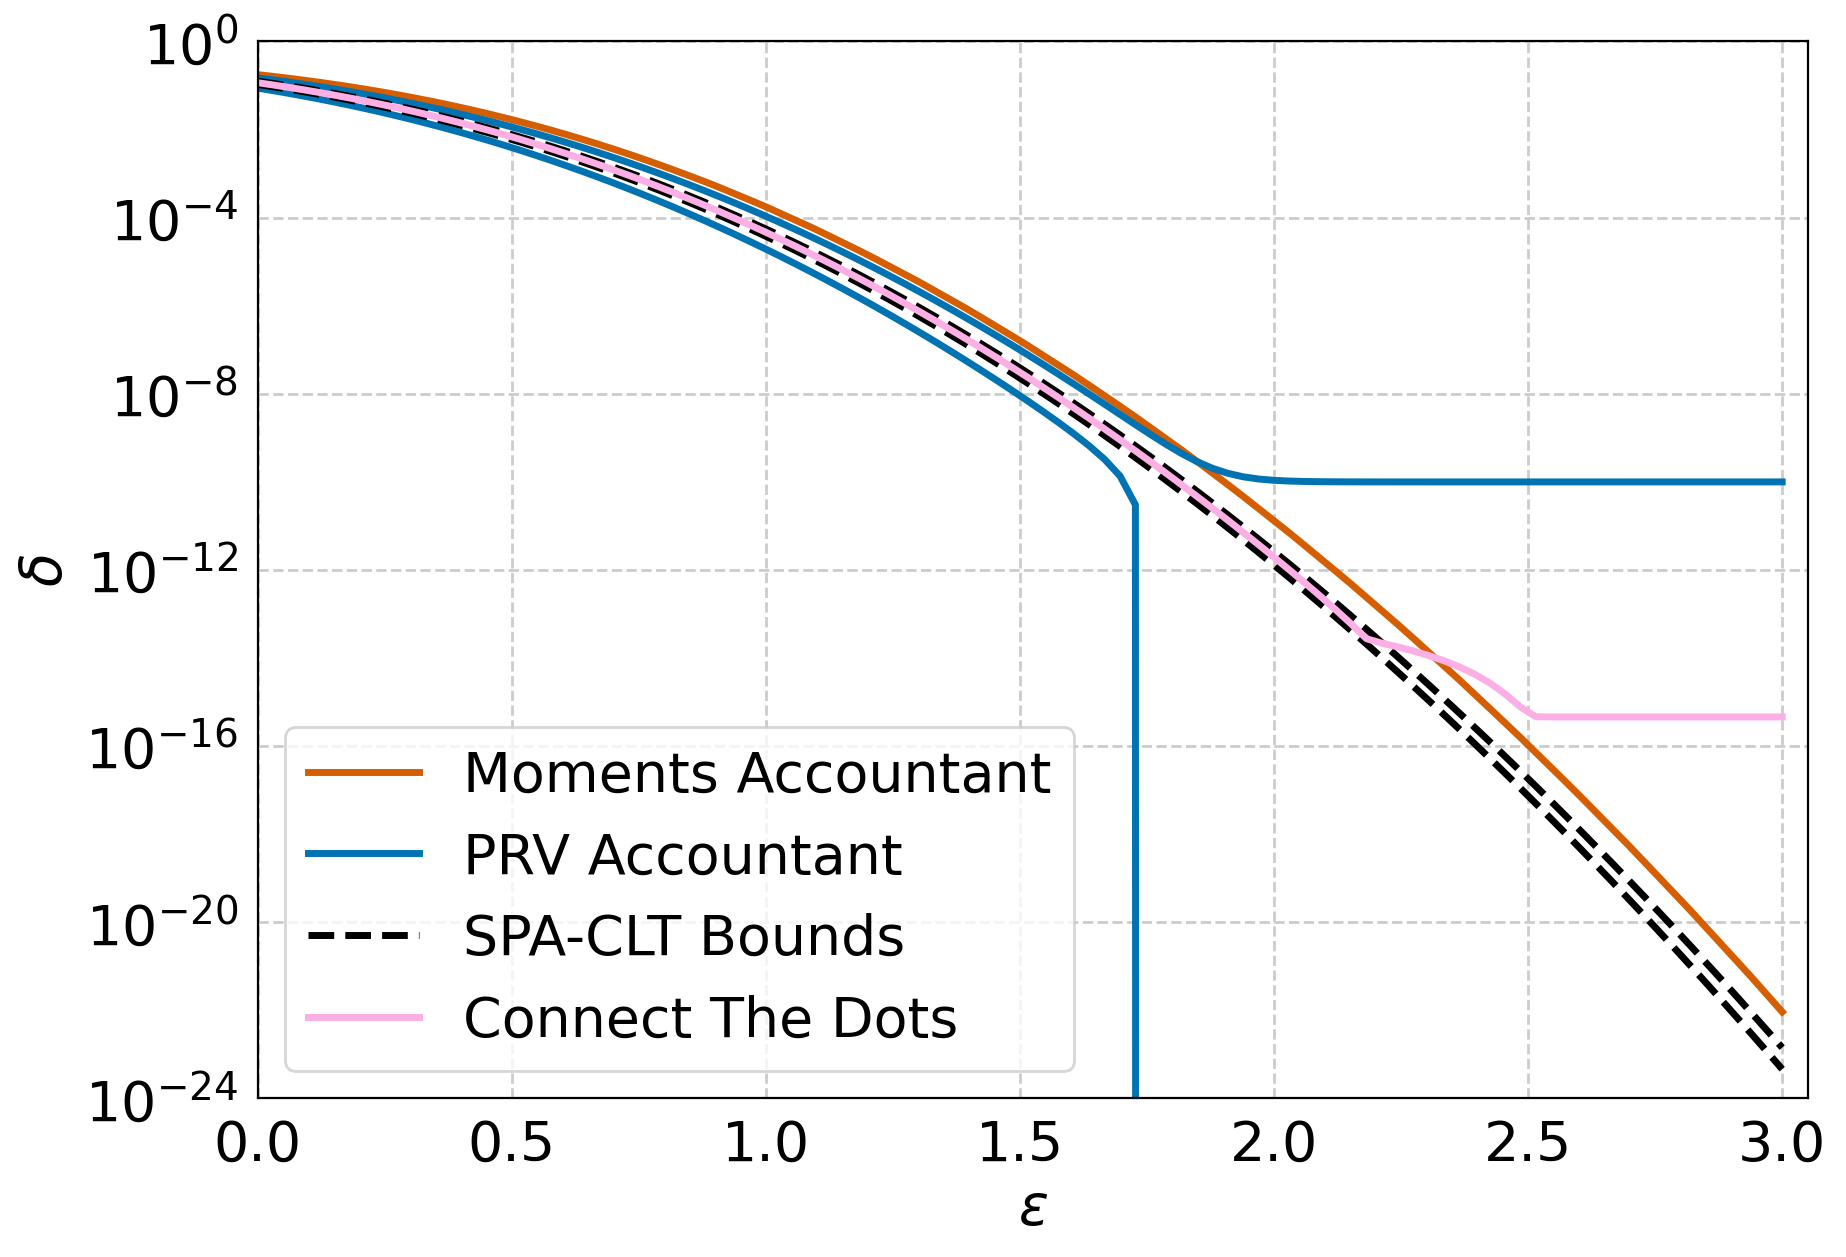

In [35]:
fig, ax = plt.subplots(figsize = (10,7), dpi = 200)
widthy = 2.5;fonty = 20

plt.plot(eps_lst, delta_rdp,c = ma_color, linewidth=widthy, label = 'Moments Accountant')

plt.plot(eps_lst, delta_prv[:,0],c = prv_color, linewidth=widthy, label = 'PRV Accountant')
plt.plot(eps_lst, delta_prv[:,2],c = prv_color, linewidth=widthy)

plt.plot(eps_lst, delta_connect_the_dots,c = ctd_color, linewidth=widthy, label = 'Connect The Dots')

plt.plot(eps_lst, delta_clt_bounds[:,0] - delta_clt_bounds[:,1],c = 'black',linestyle='--', linewidth=widthy, label = 'SPA-CLT Bounds')
plt.plot(eps_lst, delta_clt_bounds[:,0] + delta_clt_bounds[:,1],c = 'black',linestyle='--', linewidth=widthy)

plt.rcParams["axes.edgecolor"] = "black";plt.grid(color='0.8', linestyle='--', linewidth=1)
plt.yscale('log');plt.xlim([0,3.05]);plt.ylim([1e-24,1e-0]);ax.tick_params(labelsize=fonty, bottom = False, left = False)
plt.xlabel('$\epsilon$', fontsize = fonty);plt.ylabel('$\delta$', fontsize = fonty)
plt.legend(fontsize = fonty);ax.set_yticks(10**(-np.linspace(0,24,7)));

## Figure 2

In [47]:
#Initialize parameters for all accountants
#Note: paraemters such as sigma, sampling_prob, are the same as Figure 1

comps_lst = np.linspace(1.5,4.5,32)*1000
delta = 1e-15

#Saddlepoint 
eps_msd1 = [acc_spa.compute_epsilon_msd(delta, int(comps), k = 1) for comps in comps_lst]
eps_msd2 = [acc_spa.compute_epsilon_msd(delta, int(comps), k = 2) for comps in comps_lst]
eps_msd3 = [acc_spa.compute_epsilon_msd(delta, int(comps), k = 3) for comps in comps_lst]
eps_clt = np.array([acc_spa.compute_epsilon_clt(delta, int(comps)) for comps in comps_lst])

#RDP Accountant
event = dp_event.PoissonSampledDpEvent(sampling_prob, dp_event.GaussianDpEvent(sigma))
eps_rdp = np.array([])
for comps in comps_lst: 
    acc_rdp = rdp_privacy_accountant.RdpAccountant().compose(event,int(comps))
    eps_rdp = np.append(eps_rdp, acc_rdp.get_epsilon(delta))

#GDP Accountant
eps_gdp = np.array([compute_eps_gdp(delta, comps, sampling_prob, sigma)[1] for comps in comps_lst])

In [48]:
#Load the Truth Calculation
mp.mp.dps = 20
with open("../mpmath_s2_q0p01_dm15_n1.5_4.5_32_.pkl","rb") as fb:
    true = pickle.load(fb)
eps_true = np.array([mp.mpf(oop) for oop in true])

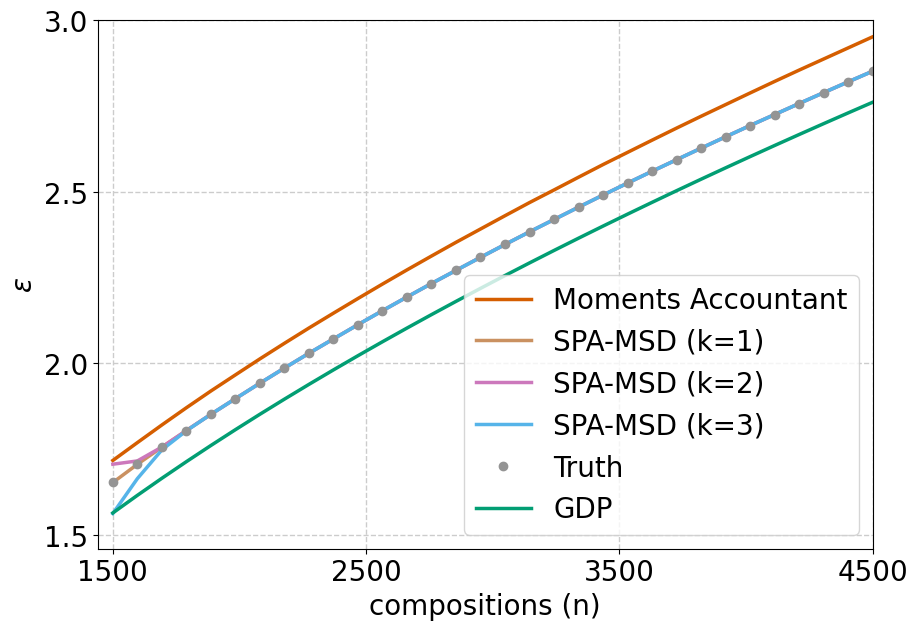

In [57]:
fig, ax = plt.subplots(dpi = 100, figsize = (10,7))
widthy = 2.5;fonty = 20

plt.plot(comps_lst, eps_rdp, c = ma_color, label = 'Moments Accountant', linewidth=widthy)

plt.plot(comps_lst, eps_msd1, c = msd1_color, label = 'SPA-MSD (k=1)', linewidth=widthy)
plt.plot(comps_lst, eps_msd2, c =msd2_color, label = 'SPA-MSD (k=2)', linewidth=widthy)
plt.plot(comps_lst, eps_msd3, c = msd3_color, label = 'SPA-MSD (k=3)', linewidth=widthy)

plt.plot(comps_lst, eps_true,  'o',  markersize = 6, markevery=1,c = true_color, label = 'Truth', linewidth=widthy)

plt.plot(comps_lst, eps_gdp, c = gdp_color, label = 'GDP', linewidth=widthy)

plt.rcParams["axes.edgecolor"] = "black";plt.grid(color='0.8', linestyle='--', linewidth=1)
plt.xlim([comps_lst[0]*0.96, comps_lst[-1]]);plt.ylim([1.46,3]);ax.set_xticks([1500,2500,3500,4500]);
ax.set_yticks([1.5,2,2.5,3]);ax.tick_params(labelsize=fonty );
plt.xlabel('compositions (n)',fontsize=fonty); plt.legend(loc = 'lower right', fontsize = fonty);
plt.ylabel('$\epsilon$',fontsize=fonty);

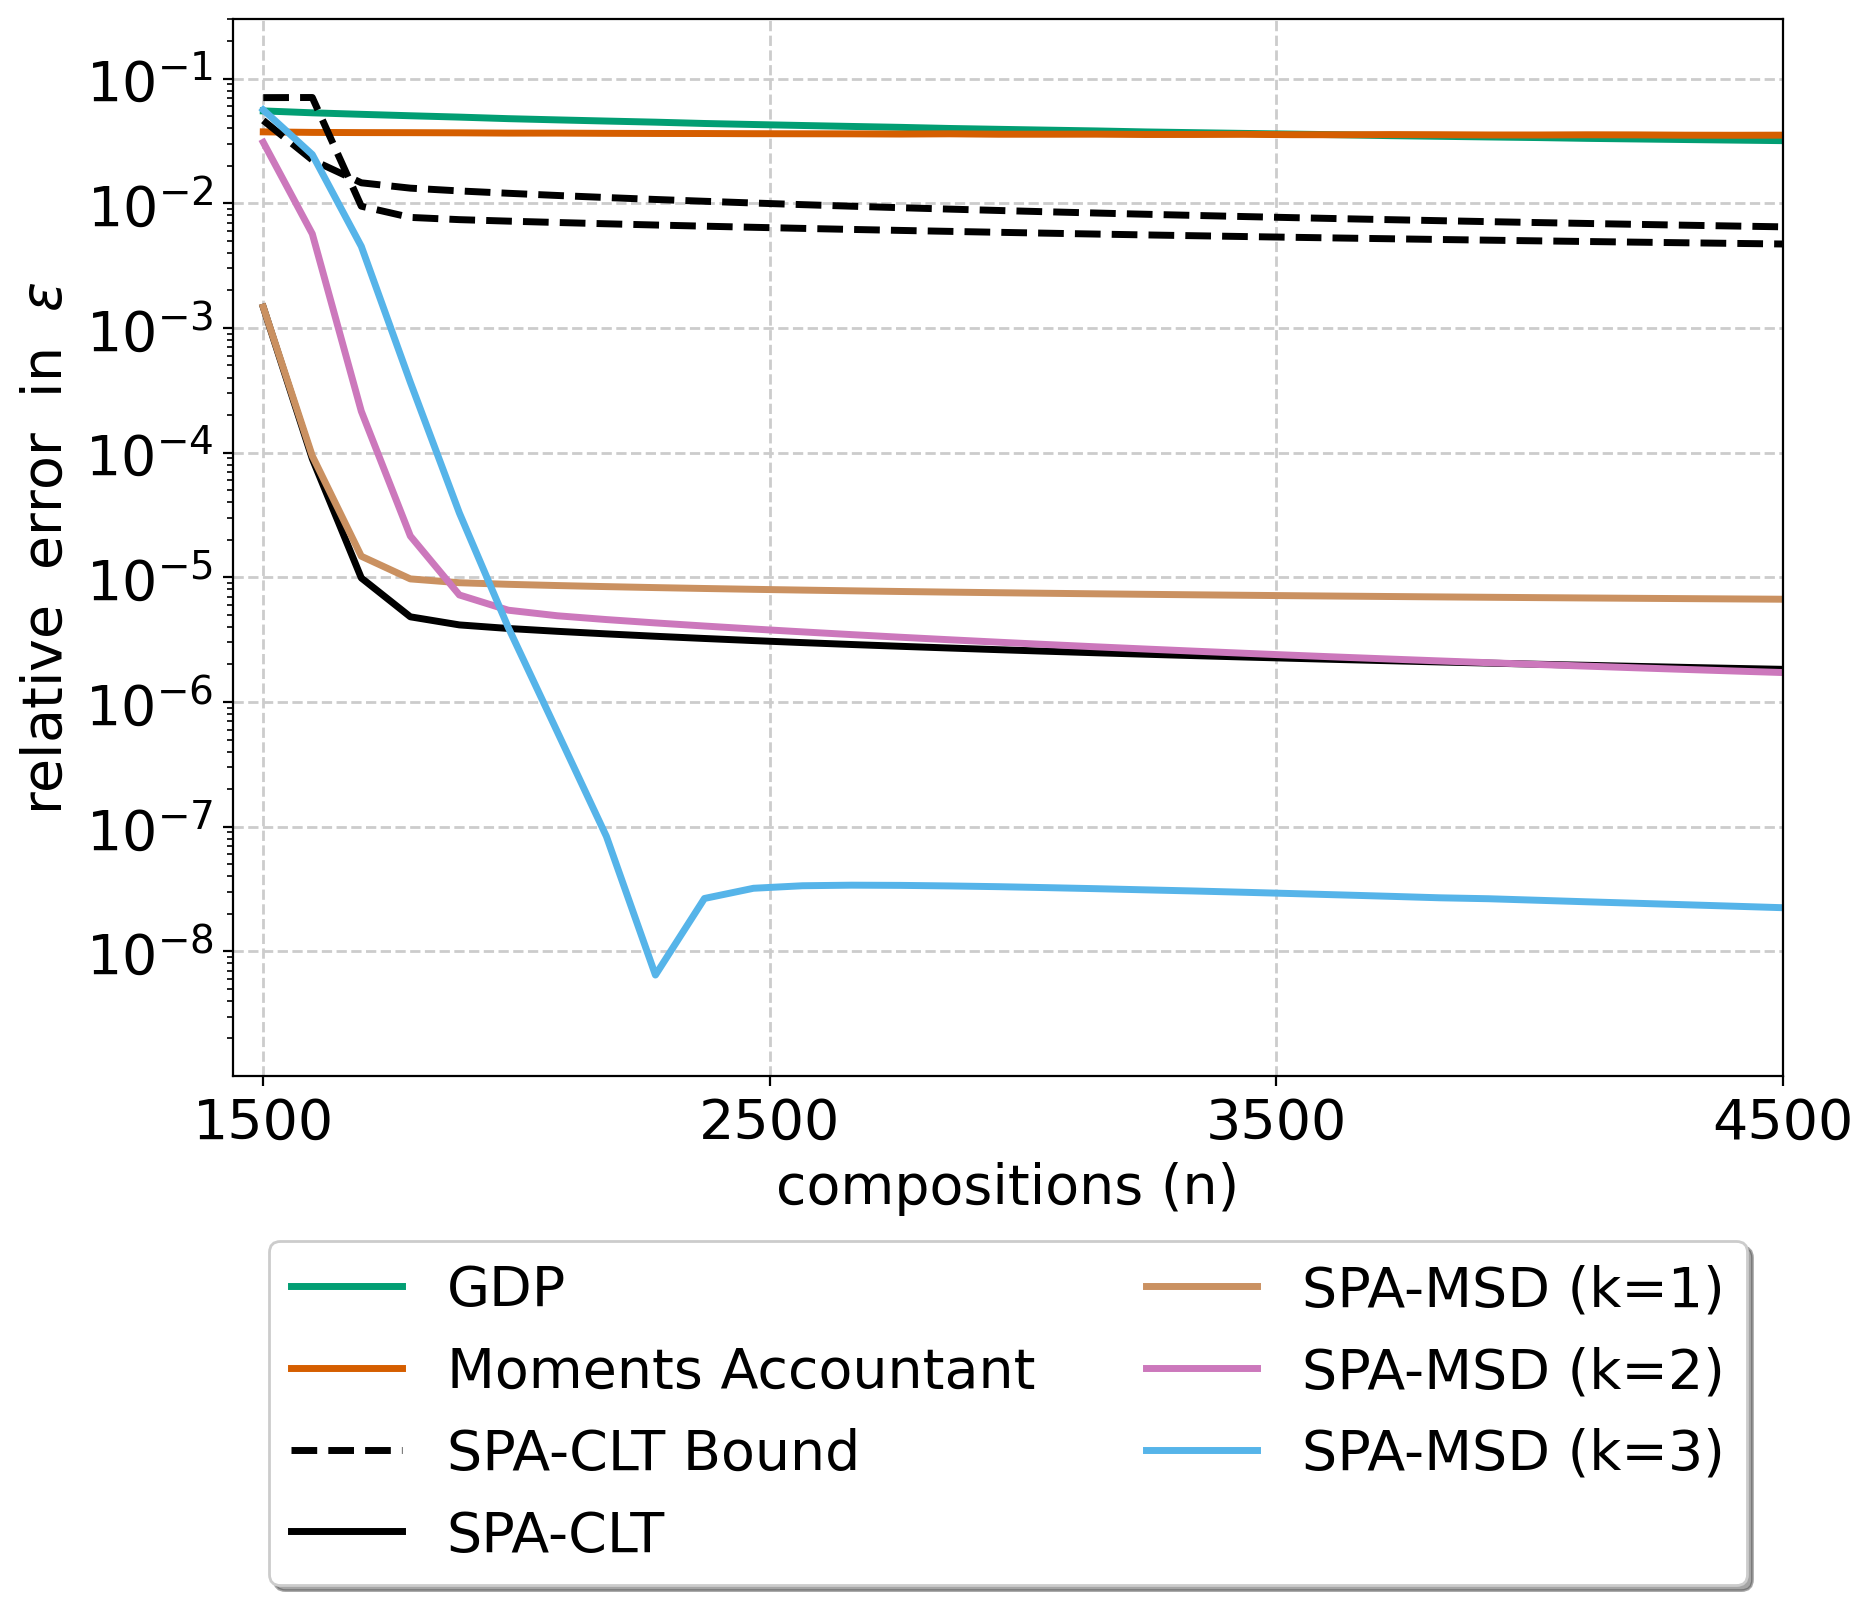

In [61]:
fig, ax = plt.subplots(dpi = 200, figsize = (10,7))
widthy = 2.5
plt.plot(comps_lst, np.abs(eps_true - eps_gdp)/eps_true, c = gdp_color, label = 'GDP', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_rdp)/eps_true, c = ma_color, label = 'Moments Accountant', linewidth=widthy)

plt.plot(comps_lst, np.abs(eps_true - eps_clt[:,2])/eps_true, '--',c = clt_bounds_color, label = 'SPA-CLT Bound', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_clt[:,0])/eps_true, '--',c = clt_bounds_color, linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_clt[:,1])/eps_true, c = clt_bounds_color, label = 'SPA-CLT', linewidth=widthy)


plt.plot(comps_lst, np.abs(eps_true - eps_msd1)/eps_true, c = msd1_color, label = 'SPA-MSD (k=1)', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_msd2)/eps_true, c = msd2_color, label = 'SPA-MSD (k=2)', linewidth=widthy)
plt.plot(comps_lst, np.abs(eps_true - eps_msd3)/eps_true, c = msd3_color, label = 'SPA-MSD (k=3)', linewidth=widthy)


plt.xlim([comps_lst[0]*0.9, comps_lst[-1]])
plt.rcParams["axes.edgecolor"] = "black"
plt.grid(color='0.8', linestyle='--', linewidth=1)
plt.yscale('log')
plt.ylim([1e-9,3e-1])
plt.xlim([comps_lst[0]*0.96, comps_lst[-1]])
ax.set_xticks([1500,2500,3500,4500])
ax.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8])
ax.tick_params(labelsize=fonty )
plt.xlabel('compositions (n)',fontsize=fonty); 
#plt.tight_layout()
lgd = ax.legend(fontsize=fonty,loc = 'upper center', bbox_to_anchor=(0.5, -.13), ncol=2, fancybox=True, shadow=True); #loc = (0.6,0.5)
plt.ylabel('relative  error  in  $\epsilon$',fontsize=fonty);

## SUPPLEMENTARY FIGURES

In [26]:
gauss = GaussianMechanism(sampling_probability = 2**14 / 50000, noise_multiplier = 9.4)
acc_spa = SaddlePointAccountant(gauss)

acc_spa.compute_delta_msd(3, 100, k = 1)

6.3670378352895354e-18

In [27]:
# fig, ax = plt.subplots(2,2, figsize = (20,10), dpi = 100)
gauss = GaussianMechanism(sampling_probability = 2**14 / 50000, noise_multiplier = 9.4)
acc_spa = SaddlePointAccountant(gauss)

eps_uppers = [3.1, 4.8, 7.1, 15]
compositions = [100, 250, 500, 2000]

delta_msd1_lst = []
delta_clt_lst = []

for index in range(4):
    eps_lst = np.linspace(0,eps_uppers[index], 100)
    delta_msd1_lst.append( np.array([acc_spa.compute_delta_msd(eps, compositions[index], k = 1) for eps in eps_lst]))
    delta_clt_lst.append(  np.array([acc_spa.compute_delta_clt(eps, compositions[index]) for eps in eps_lst]))

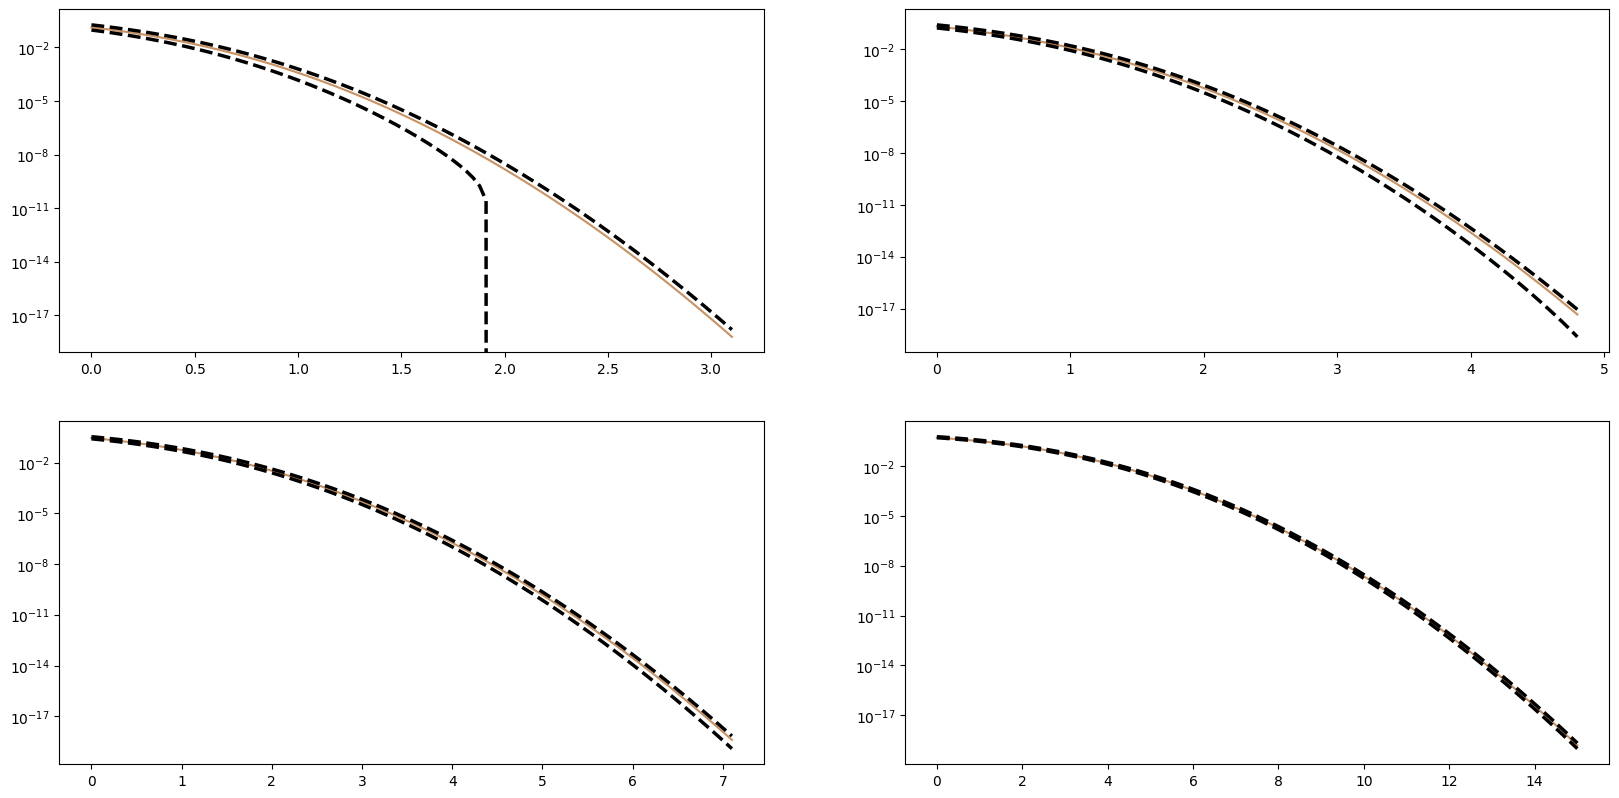

In [28]:
fig, ax = plt.subplots(2,2, figsize = (20,10), dpi = 100)
for index in range(4):
    ind1, ind2 = np.unravel_index(index, (2,2))
    eps_lst = np.linspace(0,eps_uppers[index], 100)
    delta_msd1 = delta_msd1_lst[index]
    delta_clt = delta_clt_lst[index]
    #plot result
    ax[ind1, ind2].plot(eps_lst, delta_msd1, color = msd1_color, label = 'SPA-MSD (k=1)')
    ax[ind1, ind2].plot(eps_lst, delta_clt[:,0] - delta_clt[:,1],c = 'black',linestyle='--', linewidth=widthy)
    ax[ind1, ind2].plot(eps_lst, delta_clt[:,0] + delta_clt[:,1],c = 'black',linestyle='--', linewidth=widthy)

    ax[ind1, ind2].set_yscale('log')
